In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from abbyy_course_cvdl_t3.coco_text import COCO_Text
import torchvision
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

/home/ichuviliaeva/miniconda3/envs/hw_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ../task2

/home/ichuviliaeva/cv_hw3/course_cvdl/task2


In [3]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.convert import PointsToObjects


In [4]:
%cd ../task3

/home/ichuviliaeva/cv_hw3/course_cvdl/task3


In [5]:
anno_path = Path("./abbyy_course_cvdl_t3/data/cocotext.v2.json")
images_path = Path("/DATA/ichuviliaeva/coco_text/coco2014/images/train2014")

In [6]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:01.951181
creating index...
index created!


In [7]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation

In [8]:
ds_val = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640)),
    split='val'
)

In [9]:
%ls

abbyy_course_cvdl_t3/
baseline_eval.ipynb
baseline_train.ipynb
centralnet_coco_text_third_try_epoch_0.pth
centralnet_coco_text_third_try_epoch_10.pth
centralnet_coco_text_third_try_epoch_15.pth
centralnet_coco_text_third_try_epoch_5.pth
cv-task3-third-try.ipynb
predictions.json
README.md
setup.py
third-try_eval.ipynb


In [23]:
model = torch.load('centralnet_coco_text_third_try_epoch_25.pth')
model.to(torch.device('cpu'));
model.eval();

Text(0.5, 1.0, 'GT: 101243')

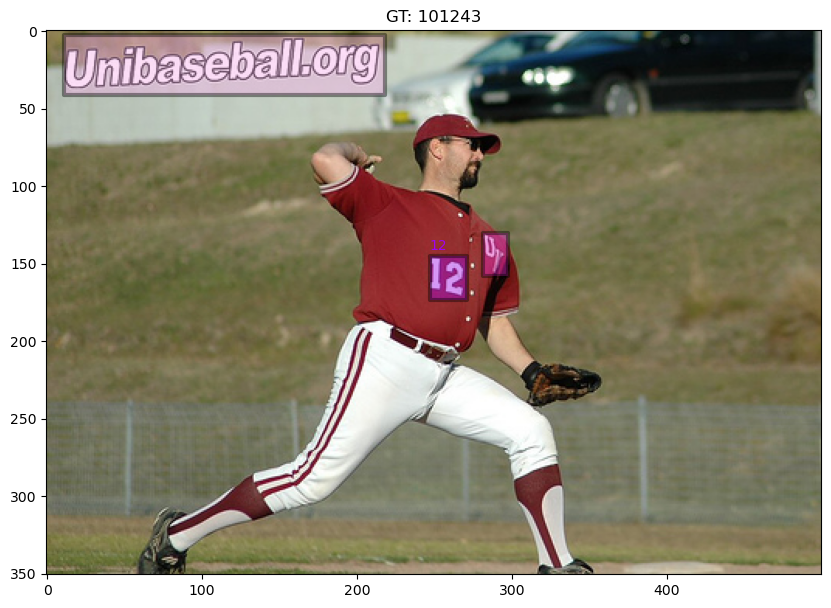

In [24]:
img_id = 101243
img_meta = ct.loadImgs(ids=[img_id])[0]
plt.imshow(plt.imread(images_path / img_meta['file_name']))
annIds = ct.getAnnIds(imgIds=img_meta['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)
plt.title(f"GT: {img_meta['id']}")

In [25]:
img, anno = ds_val[ds_val.ids.index(str(img_id))]

In [26]:
preds = model(torch.unsqueeze(img, dim = 0), return_objects = True)

In [27]:
print(preds.shape)

torch.Size([1, 42, 6])


In [28]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

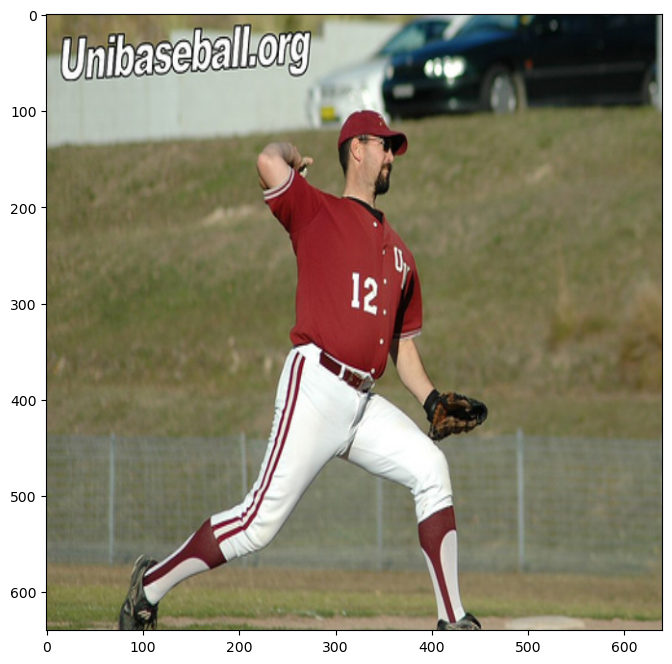

In [29]:
img_n = img.permute(1, 2, 0).numpy()
det_n = np.round(preds.detach().numpy()).astype(np.uint8)
# отрисовать одну детекцию
#det_n = det_n[_j:_j+1,]

plt.imshow(draw_boxes(
    img.permute(1, 2, 0).numpy(), 
        np.squeeze(det_n[:, :, 0]), 
        np.squeeze(det_n[:, :, 1]), 
        np.squeeze(det_n[:, :, 2]), 
        np.squeeze(det_n[:, :, 3])
))

In [39]:
def postprocess(preds, size_src=None, size_current=None):
    """
    Перевод предсказаний в
    Масштабированые боксы согласно оригинальному размеру изображения.
    """
    det_n =np.round(preds.detach().numpy()).astype(np.uint8)
    det_n = det_n[det_n[:, 5] != 0]
    boxes = det_n[:, 0:4].copy()
        
    frames = np.zeros_like(boxes)
    frames[:, 0] = (boxes[:, 1] - boxes[:, 3] / 2) * (size_src[1] / size_current[1])
    frames[:, 1] = (boxes[:, 0] - boxes[:, 2] / 2) * (size_src[0] / size_current[0])
    frames[:, 2] = boxes[:, 3] * (size_src[1] / size_current[1])
    frames[:, 3] = boxes[:, 2] * (size_src[0] / size_current[0])
        
    unf = {}
    unf["boxes"] = boxes
    unf["scores"] = preds.detach().numpy()[:, 5] 
    return unf

In [40]:
prepared_preds = []
img_ids = []

for num, img_id in enumerate(tqdm(ds_val.ids)):
    img_id = int(img_id)
    img_meta = ct.loadImgs(ids=[img_id])[0]
    with torch.no_grad():
        x = ds_val[num][0]
        preds = model(torch.unsqueeze(x, dim = 0), return_objects = True)[0]
        prepared_preds.append(
            postprocess(
                preds,
                size_src=[img_meta['width'], img_meta['height']], 
                size_current=[160, 160]
            )
        )
        img_ids.append(img_id)

100%|███████████████████████████████████████| 4446/4446 [20:49<00:00,  3.56it/s]


In [41]:
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [42]:
scores = np.concatenate([u['scores'] for u in prepared_preds])
boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)

In [43]:
image_ids = []
for num, i in enumerate(img_ids):
    image_ids += [i] * len(prepared_preds[num]['boxes'])
image_ids = np.array(image_ids)

In [44]:
dump_detections_to_cocotext_json(
    image_ids = image_ids.tolist(),
    xlefts=boxes[:, 0].tolist(),
    ytops=boxes[:, 1].tolist(),
    widths=boxes[:, 2].tolist(),
    heights=boxes[:, 3].tolist(),
    scores=scores.tolist(),
    path='predictions.json'
);
    

In [45]:
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json

In [46]:
ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path='predictions.json'
)
print(f"Итоговый скор AP на val: {ap}")

Loading and preparing results...     
DONE (t=13.03s)
Итоговый скор AP на val: 0.0


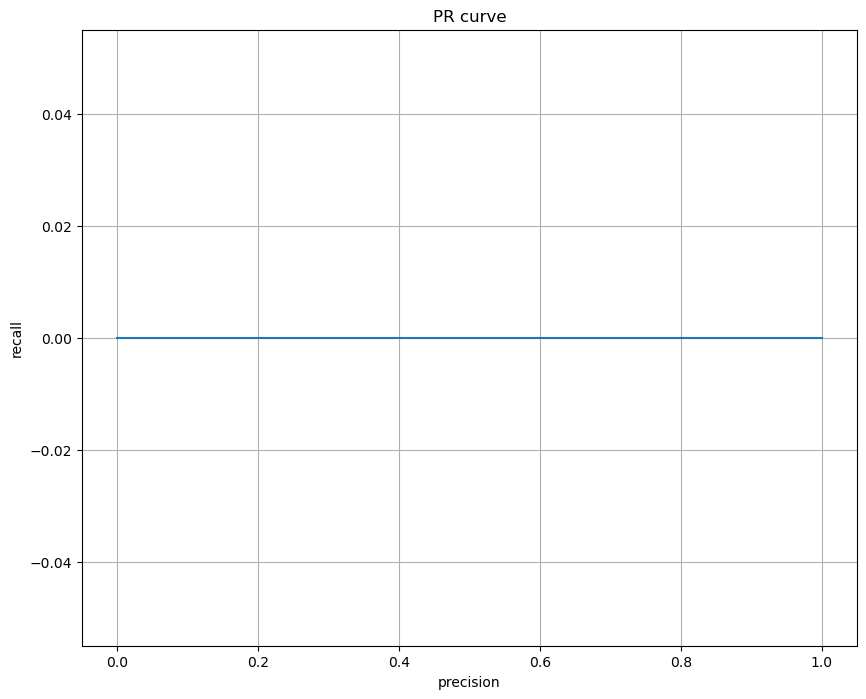

In [47]:
from matplotlib import pyplot as plt
plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()